# Stock-to-flow model in crypto and beyond Polynomial Regression

In [1]:
#!/usr/bin/python
import json
import time
import requests
import numpy as np
import scipy as sp
import pandas as pd
from datetime import datetime, date, timedelta, timezone
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
%matplotlib inline

In [2]:
print("Numpy version: {}".format(np.__version__))
print("Scipy version: {}".format(sp.__version__))
print("Pandas version: {}".format(pd.__version__))

Numpy version: 1.20.3
Scipy version: 1.6.2
Pandas version: 1.0.3


In [3]:
import seaborn as sns
print("Seaborn version: {}".format(sns.__version__))

Seaborn version: 0.9.0


/opt/conda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
# CoinMarketCap API Test (No use in this article)
API_KEY_CMC = '<CoinMarketCap API Key>'

from coinmarketcapapi import CoinMarketCapAPI, CoinMarketCapAPIError
cmc = CoinMarketCapAPI(API_KEY_CMC)

In [5]:
# Glassnode API Test (No use in this article)
API_KEY_GN = '<Glassnode API Key>'

# make API request
res = requests.get('https://api.glassnode.com/v1/metrics/indicators/sopr', params={'a': 'BTC', 'api_key': API_KEY_GN})

In [6]:
# omit small numbers for displaying float
pd.options.display.float_format = '{:.2f}'.format

headers = {'Content-Type': 'application/json'}
base_url   = "https://community-api.coinmetrics.io/v2/assets"
base_asset = "btc"
base_unit  = "PriceUSD"
base_start = "20190101"
asset_pairs = ['btc', 'ada', 'xrp', 'ltc', 'xlm']

In [7]:
# Use metric data in CoinMetrics to get the price and the supply
# https://docs.coinmetrics.io/api/v2#tag/Metrics

def coinmetrics_api(url, asset, unit, start):
    api_url = '{0}/{1}/metricdata?metrics={2}%2CSplyCur&start={3}'.format(url, asset, unit, start)
    api_cap = '{0}/{1}/metricdata?metrics=CapMrktCurUSD&start={2}'.format(url, asset, start)
    res = requests.get(api_url, headers=headers)
    cap = requests.get(api_cap, headers=headers)

    if res.status_code == 200 and cap.status_code == 200:
        dat_res = json.loads(res.text)
        dat_cap = json.loads(cap.text)
        return dat_res['metricData']['series'], dat_cap['metricData']['series']
    else:
        print("Getting data from CoinMetrics failed.")
        return None

In [8]:
def df_extraction(dat, cap):
    bstr = list()
    for i, l in enumerate(dat):
        if l['values'][0] is None or l['values'][1] is None: break
        if cap[i]['values'][0] is None: break
        d = datetime.fromisoformat(l['time'][:-1])
        d = d.strftime('%Y-%m-%d')
        # d = d.strftime('%Y-%m-%d %H:%M:%S')
        entry = [d, float(l['values'][0]), float(l['values'][1]), float(cap[i]['values'][0])]
        bstr.append(entry)
    # create a DataFrame object from list bstr with time, price, supply
    df = pd.DataFrame(bstr, columns=['time', 'price', 'supply', 'cap'])
    df['time'] = pd.to_datetime(df['time']) # convert time column to datetime
    df = df.set_index('time', drop=True) # set the column time to index
    df['supply'] = df['supply'].round()
    df['cap'] = df['cap'].round()
    ''' print(df.dtypes)
    time      datetime64[ns]
    price            float64
    supply           float64
    cap              float64
    dtype: object
    '''
    return df

In [9]:
def calc_s2f_monthly(df):
    df_d = df.copy(); df_d = df_d[df_d.index.day == 1]
    df_d['flow'] = df_d['supply'].diff().fillna(method='bfill') # use backfill
    df_d['s2f'] = df_d['supply']/(df_d['flow']*12)
    return df_d

In [10]:
def draw_s2f(df):
    # http://seaborn.pydata.org/generated/seaborn.set_theme.html#seaborn.set_theme
    sns.set('paper', 'whitegrid', 'Set2', font_scale=1, rc={"lines.linewidth": 2})

    # lineplot for market cap and s2f data points
    fig = plt.figure(figsize=(15, 7))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = ax1.twinx()
    c = ax1.plot(df.index, df['cap'], alpha=0.8, color='#d62728', marker='o')
    l = ax2.plot(df.index, df['s2f'], alpha=0.7, color='#ff7f0e', marker='o')
    ax1.legend((*c, *l), ('MarketCap', 'S2F'), loc='upper left')
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
    ax1.grid(True)
    ax2.grid(False)
    ax1.set_title('marketcap and s2f data points')
    
    # lineplot for price and s2f data points
    ax3 = fig.add_subplot(1, 2, 2)
    ax4 = ax3.twinx()
    d = ax3.plot(df.index, df['price'], alpha=0.8, color='#d62728', marker='o')
    m = ax4.plot(df.index, df['s2f'], alpha=0.7, color='#ff7f0e', marker='o')
    ax3.legend((*d, *m), ('Price', 'S2F'), loc='upper left')
    ax3.grid(True)
    ax4.grid(False)
    ax3.set_title('price and s2f data points')

In [11]:
def draw_price(df):
    sns.set_style('whitegrid')
    sns.set_palette("Set2", 8, 1.0)
    sns.set_context(context='paper', font_scale=2, rc={"lines.linewidth": 2})

    # lineplot of MarketCap and s2f
    fig = plt.figure(figsize=(15, 7))
    ax1 = fig.add_subplot(1, 1, 1)
    ax1.plot(df.index, df['price'], alpha=0.8, color='#d62728', marker='o')
    ax1.legend(loc='upper left')
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
    ax1.set_yscale('log')
    ax1.grid(False)
    ax1.set_title('Price and S2F model data')

In [12]:
btc, btc_cap = coinmetrics_api(base_url, base_asset, base_unit, base_start)

In [13]:
ada, ada_cap = coinmetrics_api(base_url, asset_pairs[1], base_unit, base_start)

In [14]:
xrp, xrp_cap = coinmetrics_api(base_url, asset_pairs[2], base_unit, base_start)

In [15]:
ltc, ltc_cap = coinmetrics_api(base_url, asset_pairs[3], base_unit, base_start)

In [16]:
xlm, xlm_cap = coinmetrics_api(base_url, asset_pairs[4], base_unit, base_start)

In [17]:
dfbtc = df_extraction(btc, btc_cap)
dfada = df_extraction(ada, ada_cap)
dfxrp = df_extraction(xrp, xrp_cap)
dfltc = df_extraction(ltc, ltc_cap)
dfxlm = df_extraction(xlm, xlm_cap)

In [18]:
# add columns flow and s2f for the given DataFrame and pick the first day of months
dfbtc_s2f = calc_s2f_monthly(dfbtc)
dfada_s2f = calc_s2f_monthly(dfada)
dfxrp_s2f = calc_s2f_monthly(dfxrp)
dfltc_s2f = calc_s2f_monthly(dfltc)
dfxlm_s2f = calc_s2f_monthly(dfxlm)

In [19]:
dfada_s2f.head(len(dfada_s2f))

,price,supply,cap,flow,s2f
time,,,,,
2019-01-01,0.04,31112328887.00,1308858342.00,-9153.00,-283261.67
2019-02-01,0.04,31112319734.00,1197469175.00,-9153.00,-283261.59
2019-03-01,0.04,31112312471.00,1336824720.00,-7263.00,-356972.70
2019-04-01,0.07,31112297736.00,2245419750.00,-14735.00,-175954.63
2019-05-01,0.07,31112281630.00,2117357788.00,-16106.00,-160976.66
2019-06-01,0.09,31112261894.00,2827976695.00,-19736.00,-131368.49
2019-07-01,0.08,31112242691.00,2591652572.00,-19203.00,-135014.68
2019-08-01,0.06,31112227644.00,1828991399.00,-15047.00,-172305.82
2019-09-01,0.04,31112216391.00,1386192027.00,-11253.00,-230399.42


In [20]:
dfxrp_s2f.head(len(dfxrp_s2f))

,price,supply,cap,flow,s2f
time,,,,,
2019-01-01,0.36,99991657279.00,36129213596.00,-23881.00,-348923.33
2019-02-01,0.31,99991633398.00,30548648845.00,-23881.00,-348923.25
2019-03-01,0.32,99991612274.00,31519805332.00,-21124.00,-394462.90
2019-04-01,0.31,99991591152.00,31214781143.00,-21122.00,-394500.17
2019-05-01,0.30,99991565089.00,29926859137.00,-26063.00,-319711.10
2019-06-01,0.43,99991536509.00,42920051658.00,-28580.00,-291554.52
2019-07-01,0.41,99991501564.00,40633136681.00,-34945.00,-238449.71
2019-08-01,0.32,99991312824.00,31613735126.00,-188740.00,-44148.61
2019-09-01,0.26,99991288868.00,25682808456.00,-23956.00,-347829.66


In [21]:
dfxlm_s2f.head(len(dfxlm_s2f))

,price,supply,cap,flow,s2f
time,,,,,
2019-01-01,0.11,104601409578.00,11918755628.00,79796555.00,109.24
2019-02-01,0.08,104681206133.00,8438426523.00,79796555.00,109.32
2019-03-01,0.08,104761067700.00,8881165224.00,79861567.00,109.32
2019-04-01,0.11,104840766974.00,11562845640.00,79699274.00,109.62
2019-05-01,0.10,104940750480.00,10464857451.00,99983506.00,87.47
2019-06-01,0.13,105020962389.00,13987754864.00,80211909.00,109.11
2019-07-01,0.11,105101084671.00,11098760453.00,80122282.00,109.31
2019-08-01,0.08,105201351046.00,8721230047.00,100266375.00,87.43
2019-09-01,0.06,105281618517.00,6566289539.00,80267471.00,109.30


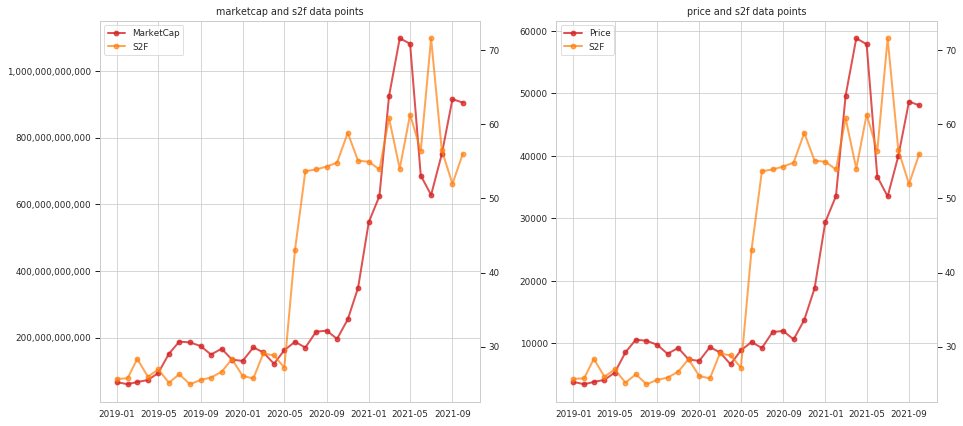

In [22]:
draw_s2f(dfbtc_s2f)

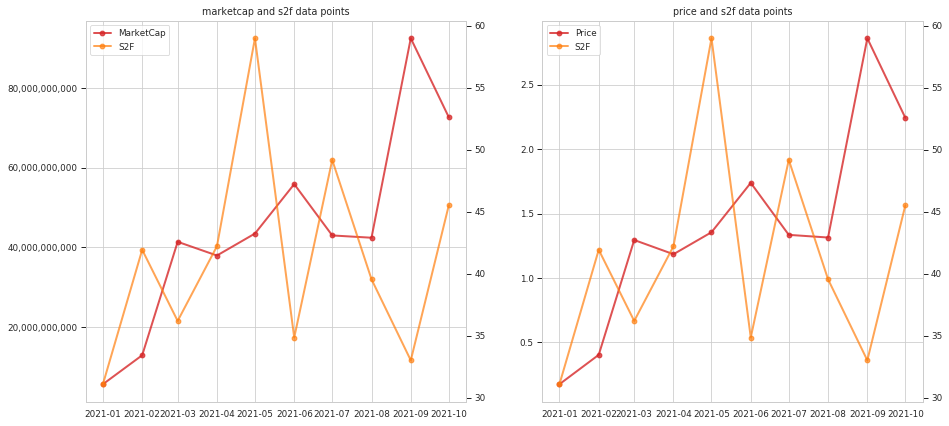

In [23]:
# Supply data might not be accurate for ADA, XRP and XLM for the given data points
# just 10 data points are shown for ADA here
draw_s2f(dfada_s2f[-10:])

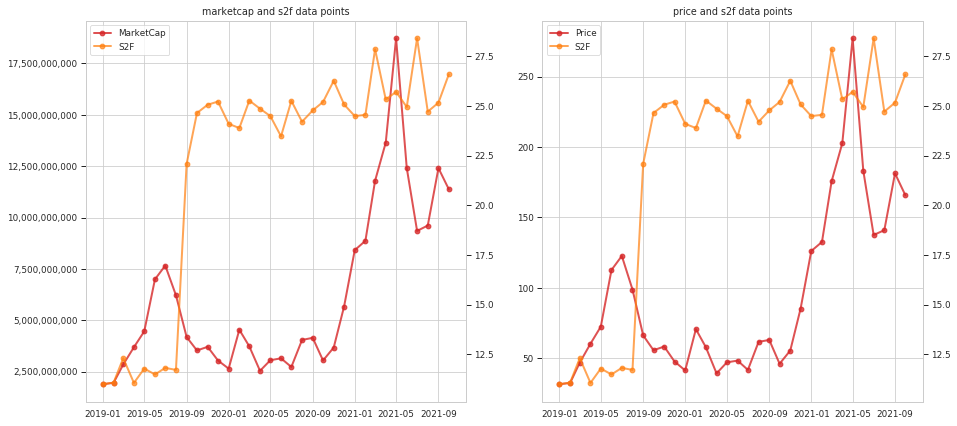

In [24]:
draw_s2f(dfltc_s2f)

## Scatter plot and regression model

In [25]:
def scatter_s2f(df):
    # http://seaborn.pydata.org/generated/seaborn.set_theme.html#seaborn.set_theme
    sns.set('paper', 'whitegrid', 'Set2', font_scale=1, rc={"lines.linewidth": 2})

    fig = plt.figure(figsize=(15, 15))
    # width spacing and height spacing between figures
    plt.subplots_adjust(wspace=0.3, hspace=0.18)
    ax1 = fig.add_subplot(2, 2, 1)
    ax1.scatter(df['s2f'], df['cap'], label="observed")
    ax1.legend(loc='upper left')
    ax1.set_title('s2f and marketcap scatter plot')
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
    ax2 = fig.add_subplot(2, 2, 2)
    ax2.scatter(df['s2f'], df['price'], label="observed")
    ax2.legend(loc='upper left')
    ax2.set_title('s2f and price scatter plot')
    ax3 = fig.add_subplot(2, 2, 3)
    ax3.scatter(df['lns2f'], df['lncap'], label="observed")
    ax3.legend(loc='upper left')
    ax3.set_title('s2f and markcetcap scatter plot (log)')
    ax4 = fig.add_subplot(2, 2, 4)
    ax4.scatter(df['lns2f'], df['lnprice'], label="observed")
    ax4.legend(loc='upper left')
    ax4.set_title('s2f and price scatter plot (log)')

In [26]:
def scatter_reg_s2f(df, model, model2):
    import math
    # http://seaborn.pydata.org/generated/seaborn.set_theme.html#seaborn.set_theme
    sns.set('paper', 'whitegrid', 'Set2', font_scale=1, rc={"lines.linewidth": 2})
    
    X = df['lns2f'].values.reshape(-1, 1)
    y = df['lncap'].values
    y_pred = model.predict(X)
    
    X2 = df['lns2f'].values.reshape(-1, 1)
    y2 = df['lnprice'].values
    y2_pred = model2.predict(X2)
    # predicted price from the model
    df['predprice'] = np.exp(y2_pred)

    fig = plt.figure(figsize=(15, 7))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.plot(df['lns2f'], y_pred, alpha=0.8, color='#d62728', label="fitted")
    ax1.scatter(df['lns2f'], df['lncap'], alpha=0.7, color='#ff7f0e', marker='o', label="observed")
    ax1.legend(loc='upper left')
    ax1.set_title('s2f and marketcap with a fitted line')
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
    
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.plot(df.index, df['price'], alpha=0.8, color='#d62728', label="price")
    ax2.plot(df.index, df['predprice'], alpha=0.5, color='#800080', label='predicted')
    ax2.set_yscale('log')
    ax2.legend(loc='upper left')
    ax2.set_title('price and predicted price')
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

## Fit a linear regression model for data points

In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import f_regression

## More data points from 2010 August

In [28]:
btc2, btc_cap2 = coinmetrics_api(base_url, base_asset, base_unit, '20100801')

In [29]:
dfbtc2 = df_extraction(btc2, btc_cap2)
dfbtc2.head(10)

,price,supply,cap
time,,,
2010-08-01,0.06,3584000.00,218982.00
2010-08-02,0.06,3596100.00,215766.00
2010-08-03,0.06,3607450.00,216491.00
2010-08-04,0.06,3619600.00,206374.00
2010-08-05,0.06,3630500.00,221460.00
2010-08-06,0.06,3637850.00,224351.00
2010-08-07,0.06,3645600.00,215105.00
2010-08-08,0.06,3655550.00,222623.00
2010-08-09,0.07,3665050.00,258020.00


In [30]:
dfbtc_s2f_2 = calc_s2f_monthly(dfbtc2)

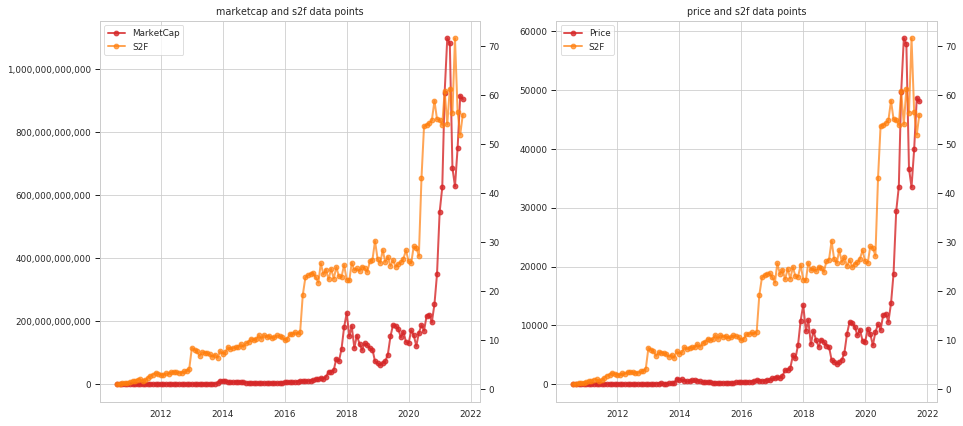

In [31]:
draw_s2f(dfbtc_s2f_2)

In [32]:
df22 = dfbtc_s2f_2.copy()

In [33]:
df22['lns2f'] = np.log(df22['s2f'])
df22['lncap'] = np.log(df22['cap'])
df22['lnprice'] = np.log(df22['price'])
df22.head(5)

,price,supply,cap,flow,s2f,lns2f,lncap,lnprice
time,,,,,,,,
2010-08-01,0.06,3584000.00,218982.00,296700.00,1.01,0.01,12.30,-2.80
2010-09-01,0.06,3880700.00,240700.00,296700.00,1.09,0.09,12.39,-2.78
2010-10-01,0.06,4157800.00,257673.00,277100.00,1.25,0.22,12.46,-2.78
2010-11-01,0.19,4453700.00,866356.00,295900.00,1.25,0.23,13.67,-1.64
2010-12-01,0.23,4749600.00,1080534.00,295900.00,1.34,0.29,13.89,-1.48


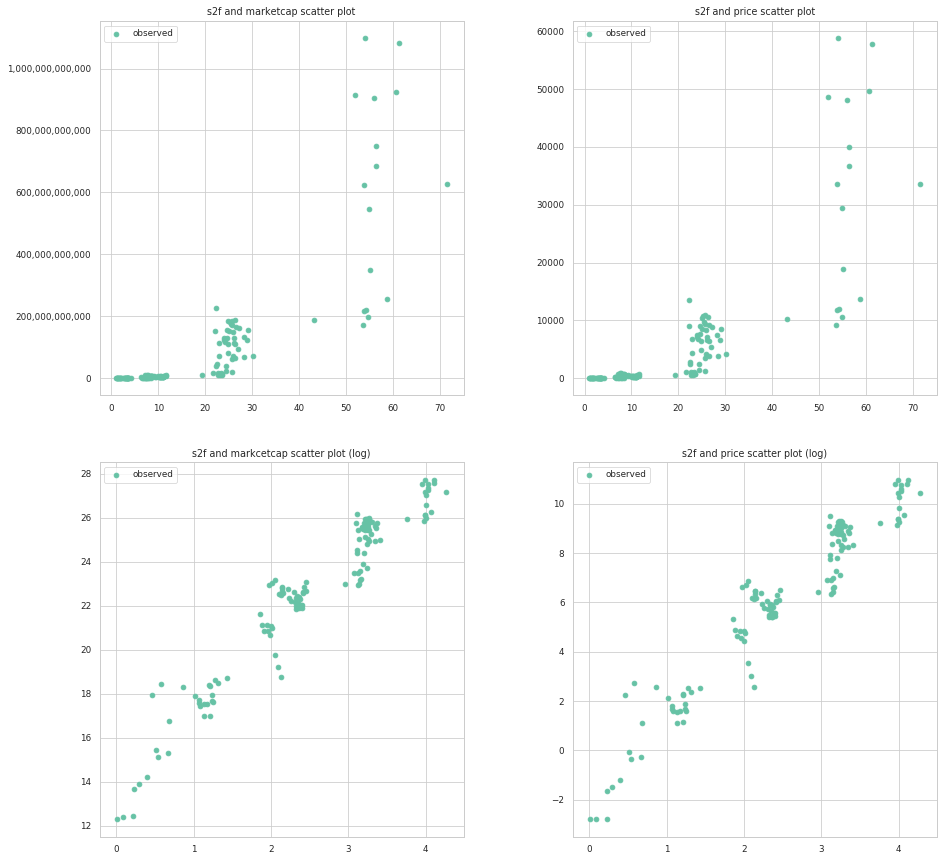

In [34]:
scatter_s2f(df22)

In [35]:
# Model initialization for logarithm marketcap
clf_reg = LinearRegression()
# Fit the data(train the model)
X3 = df22['lns2f'].values.reshape(-1, 1)
y3 = df22['lncap'].values
clf_reg.fit(X3, y3)
# Predict
lncap_pred = clf_reg.predict(X3)

# model evaluation
print("RMSE value: {}".format(mean_squared_error(y3, lncap_pred)))
print("R2 score: {}".format(r2_score(y3, lncap_pred)))
print("Slope: {0}, Intercept: {1}".format(clf_reg.coef_, clf_reg.intercept_))
f_statistic_3, p_value_3 = f_regression(X3, y3)
print("F-statistic: {0}, P-value: {1}".format(f_statistic_3, p_value_3))

RMSE value: 0.9655475133041838
R2 score: 0.9290861664837493
Slope: [3.34754805], Intercept: 14.138984154543218
F-statistic: [1742.51558568], P-value: [2.68246322e-78]


In [36]:
# Model initialization for logarithm price
clf_reg2 = LinearRegression()
# Fit the data(train the model)
X4 = df22['lns2f'].values.reshape(-1, 1)
y4 = df22['lnprice'].values
clf_reg2.fit(X4, y4)
# Predict
lnprice_pred = clf_reg2.predict(X4)

# model evaluation
print("RMSE value: {}".format(mean_squared_error(y4, lnprice_pred)))
print("R2 score: {}".format(r2_score(y4, lnprice_pred)))
print("Slope: {0}, Intercept: {1}".format(clf_reg2.coef_, clf_reg2.intercept_))
f_statistic_4, p_value_4 = f_regression(X4, y4)
print("F-statistic: {0}, P-value: {1}".format(f_statistic_4, p_value_4))

RMSE value: 0.8332501963858202
R2 score: 0.924236842512823
Slope: [3.00073606], Intercept: -1.385321789425543
F-statistic: [1622.47065897], P-value: [2.18778346e-76]


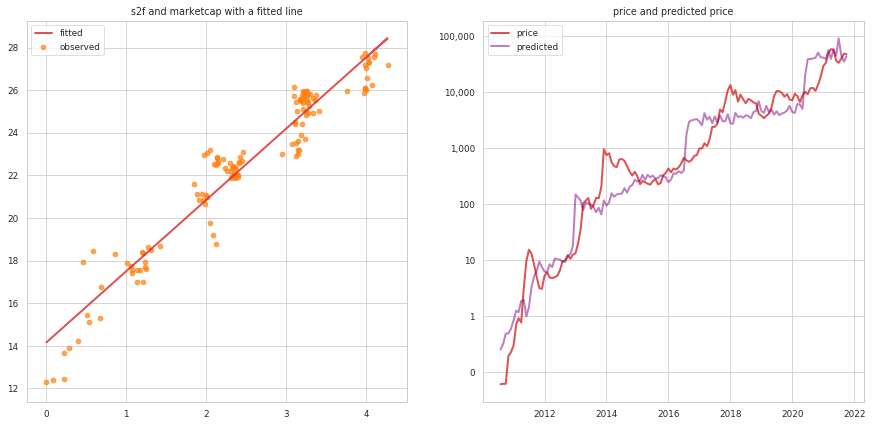

In [37]:
scatter_reg_s2f(df22, clf_reg, clf_reg2)

## Do the same for LTC

In [38]:
ltc2, ltc_cap2 = coinmetrics_api(base_url, asset_pairs[3], base_unit, '20130401')

In [39]:
dfltc2 = df_extraction(ltc2, ltc_cap2)
dfltc2.head(10)

,price,supply,cap
time,,,
2013-04-01,1.52,16260829.00,24662480.00
2013-04-02,4.61,16305879.00,75244144.00
2013-04-03,4.61,16350654.00,75450760.00
2013-04-04,5.40,16389254.00,88505324.00
2013-04-05,3.73,16428529.00,61217116.00
2013-04-06,3.73,16458479.00,61328717.00
2013-04-07,3.73,16488179.00,61439388.00
2013-04-08,4.26,16526179.00,70481032.00
2013-04-09,4.50,16560029.00,74517994.00


In [40]:
dfltc_s2f_2 = calc_s2f_monthly(dfltc2)

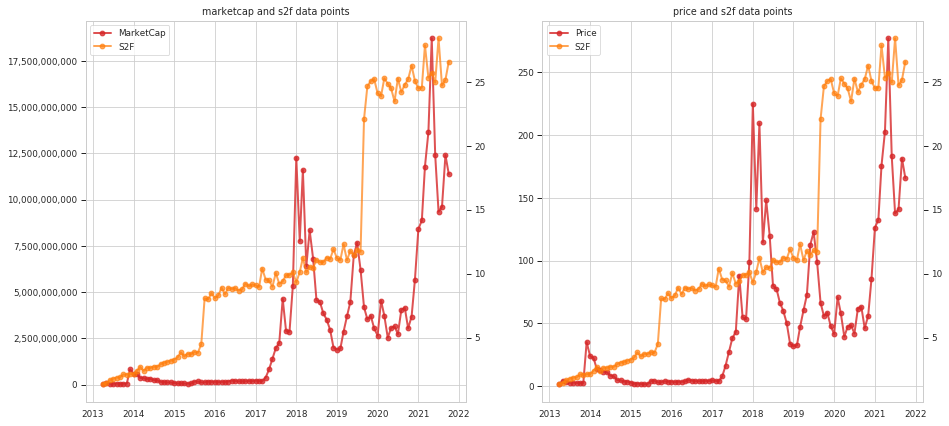

In [41]:
draw_s2f(dfltc_s2f_2)

In [42]:
df23 = dfltc_s2f_2.copy()

In [43]:
df23['lns2f'] = np.log(df23['s2f'])
df23['lncap'] = np.log(df23['cap'])
df23['lnprice'] = np.log(df23['price'])
df23.head(5)

,price,supply,cap,flow,s2f,lns2f,lncap,lnprice
time,,,,,,,,
2013-04-01,1.52,16260829.00,24662480.00,999300.00,1.36,0.30,17.02,0.42
2013-05-01,4.35,17260129.00,75082379.00,999300.00,1.44,0.36,18.13,1.47
2013-06-01,2.82,18169204.00,51292351.00,909075.00,1.67,0.51,17.75,1.04
2013-07-01,2.67,19062104.00,50838936.00,892900.00,1.78,0.58,17.74,0.98
2013-08-01,2.74,19950529.00,54714959.00,888425.00,1.87,0.63,17.82,1.01


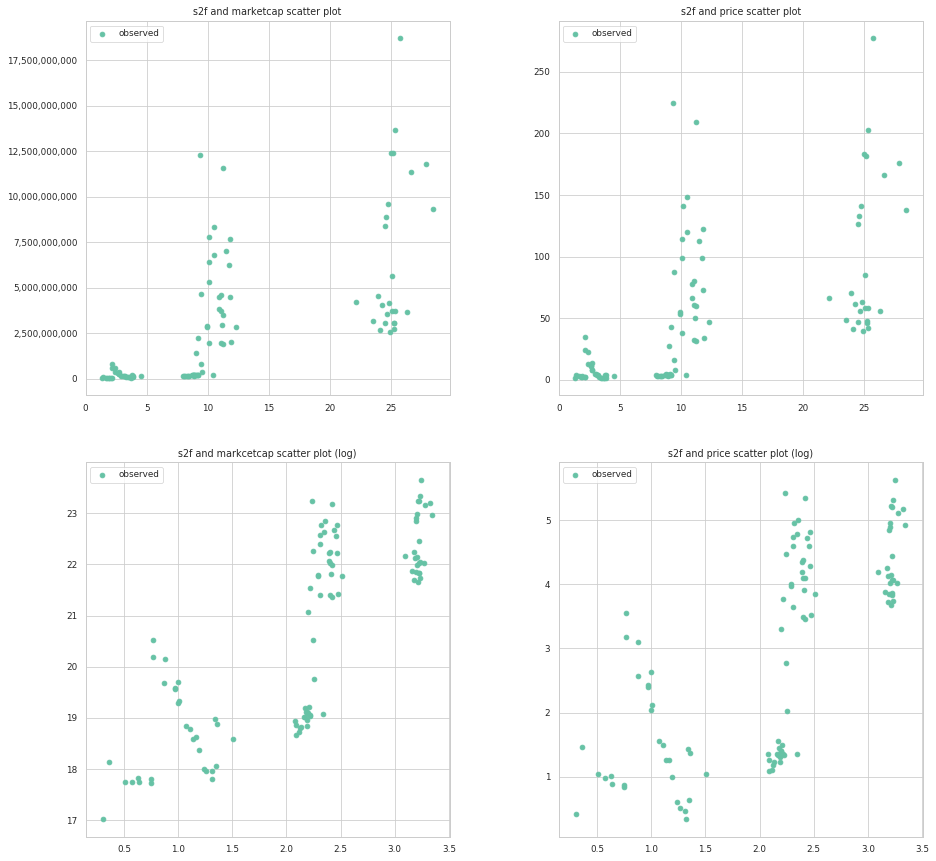

In [44]:
scatter_s2f(df23)

In [45]:
# Model initialization for logarithm marketcap
clf_reg3 = LinearRegression()
# Fit the data(train the model)
X5 = df23['lns2f'].values.reshape(-1, 1)
y5 = df23['lncap'].values
clf_reg3.fit(X5, y5)
# Predict
lncap_pred_ltc = clf_reg3.predict(X5)

# model evaluation
print("RMSE value: {}".format(mean_squared_error(y5, lncap_pred_ltc)))
print("R2 score: {}".format(r2_score(y5, lncap_pred_ltc)))
print("Slope: {0}, Intercept: {1}".format(clf_reg3.coef_, clf_reg3.intercept_))
f_statistic_5, p_value_5 = f_regression(X5, y5)
print("F-statistic: {0}, P-value: {1}".format(f_statistic_5, p_value_5))

RMSE value: 1.295592692853654
R2 score: 0.6265166202843409
Slope: [1.71572674], Intercept: 16.934506876879198
F-statistic: [169.42702697], P-value: [2.49723157e-23]


In [46]:
# Model initialization for logarithm price
clf_reg4 = LinearRegression()
# Fit the data(train the model)
X6 = df23['lns2f'].values.reshape(-1, 1)
y6 = df23['lnprice'].values
clf_reg4.fit(X6, y6)
# Predict
lnprice_pred_ltc = clf_reg4.predict(X6)

# model evaluation
print("RMSE value: {}".format(mean_squared_error(y6, lnprice_pred_ltc)))
print("R2 score: {}".format(r2_score(y6, lnprice_pred_ltc)))
print("Slope: {0}, Intercept: {1}".format(clf_reg4.coef_, clf_reg4.intercept_))
f_statistic_6, p_value_6 = f_regression(X6, y6)
print("F-statistic: {0}, P-value: {1}".format(f_statistic_6, p_value_6))

RMSE value: 1.256024262876439
R2 score: 0.5000356625956124
Slope: [1.30440726], Intercept: 0.161955850919699
F-statistic: [101.01440872], P-value: [6.94231947e-17]


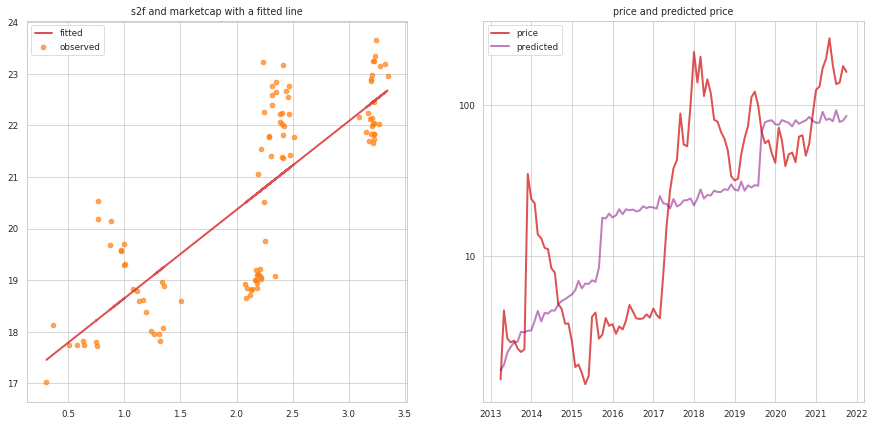

In [47]:
scatter_reg_s2f(df23, clf_reg3, clf_reg4)

In [48]:
dfada_s2f.tail(10)

,price,supply,cap,flow,s2f
time,,,,,
2021-01-01,0.18,31812864816.00,5588692166.00,85314543.00,31.07
2021-02-01,0.40,31876233440.00,12867588669.00,63368624.00,41.92
2021-03-01,1.29,31949828439.00,41369381573.00,73594999.00,36.18
2021-04-01,1.18,32013036951.00,37922702654.00,63208512.00,42.21
2021-05-01,1.36,32058328658.00,43442870503.00,45291707.00,58.98
2021-06-01,1.74,32135193090.00,55864905605.00,76864432.00,34.84
2021-07-01,1.33,32189747013.00,42968564697.00,54553923.00,49.17
2021-08-01,1.31,32257730083.00,42393986164.00,67983070.00,39.54
2021-09-01,2.86,32339400342.00,92510564145.00,81670259.00,33.00


## Polynomial Testing

In [49]:
from sklearn.preprocessing import PolynomialFeatures

In [50]:
# generate data set for polynomial testing
np.random.seed(0)
X_ = np.linspace(-5, 5, 20)
y_ = 2 * X_ - 2 * (X_ ** 2) + 0.5 * (X_ ** 3) + np.random.normal(loc=0, scale=10, size=len(X_))
X_ = X_[:, np.newaxis]
y_ = y_[:, np.newaxis]
print('X shape: {}'.format(X_.shape))
print('y shape: {}'.format(y_.shape))

X shape: (20, 1)
y shape: (20, 1)


In [51]:
def test_polynomial_features(X, y, degree):
    from sklearn.preprocessing import PolynomialFeatures
    # http://seaborn.pydata.org/generated/seaborn.set_theme.html#seaborn.set_theme
    sns.set('paper', 'whitegrid', 'Set2', font_scale=1, rc={"lines.linewidth": 2})
    
    fig, axes = plt.subplots(1, degree-1, figsize=(15, 7))
    for d, ax in zip(list(range(1, degree+1)), axes):
        i = d + 1
        poly = PolynomialFeatures(degree=i, include_bias=False)
        X_ = poly.fit_transform(X)
        clf_reg = LinearRegression()
        clf_reg.fit(X_, y)
        y_pred = clf_reg.predict(X_)
        
        # model evaluation
        print('Result of polynoial regression degree {}'.format(i))
        print("RMSE value: {}".format(mean_squared_error(y, y_pred)))
        print("R2 score: {}".format(r2_score(y, y_pred)))
        print("Slope: {0}, Intercept: {1}".format(clf_reg.coef_, clf_reg.intercept_))
        ax.scatter(X, y, alpha=0.5, color='green', label="observation")
        ax.plot(X, y_pred, alpha=0.7, color='navy', label="fitted")
        ax.legend(loc="upper left")
        ax.set_title('Polynomial Regression, degree={}'.format(i))

Result of polynoial regression degree 2
RMSE value: 121.17090856625084
R2 score: 0.8936968806347744
Slope: [[ 9.124547   -1.93365055]], Intercept: [5.08223254]
Result of polynoial regression degree 3
RMSE value: 53.35024435817458
R2 score: 0.9531958828956855
Slope: [[ 2.84104635 -1.93365055  0.38027556]], Intercept: [5.08223254]
Result of polynoial regression degree 4
RMSE value: 48.93272843587041
R2 score: 0.9570713652861615
Slope: [[ 2.84104635 -1.05654833  0.38027556 -0.03734519]], Intercept: [2.68724529]


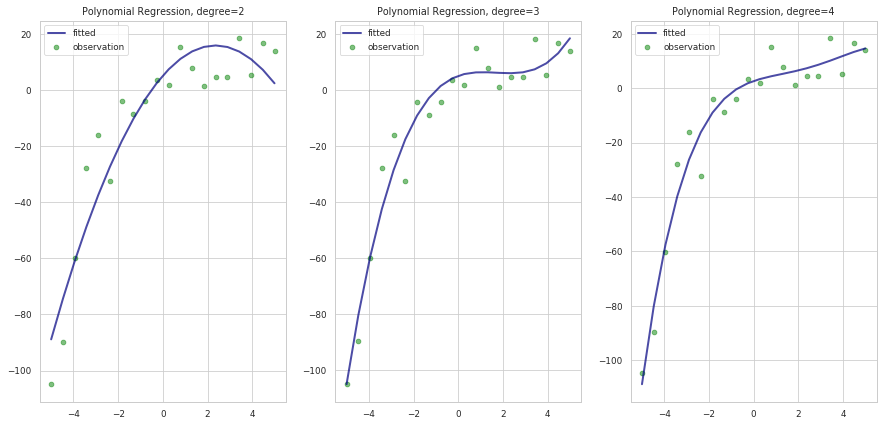

In [52]:
test_polynomial_features(X_, y_, 4)

## Polynomial degree 2 for Bitcoin marketcap and price

In [53]:
poly2d = PolynomialFeatures(degree=2, include_bias=False)
X7 = poly2d.fit_transform(df22['lns2f'].values.reshape(-1, 1))
y7 = df22['lncap'].values

# Model initialization for logarithm price
clf_reg5 = LinearRegression()
# Fit the data(train the model)
clf_reg5.fit(X7, y7)
# Predict
lncap_pred_2d = clf_reg5.predict(X7)
# print('Predicted ln(marketcap): {}'.format(lncap_pred_2d))

In [54]:
# model evaluation
print("RMSE value: {}".format(mean_squared_error(y7, lncap_pred_2d)))
print("R2 score: {}".format(r2_score(y7, lncap_pred_2d)))
print("Slope: {0}, Intercept: {1}".format(clf_reg5.coef_, clf_reg5.intercept_))
f_statistic_5, p_value_5 = f_regression(X7, y7)
print("F-statistic: {0}, P-value: {1}".format(f_statistic_5, p_value_5))

RMSE value: 0.7885547671768061
R2 score: 0.9420852514169283
Slope: [ 4.88866069 -0.34410739], Intercept: 12.823011544354943
F-statistic: [1742.51558568  603.35556066], P-value: [2.68246322e-78 2.86127359e-51]


In [55]:
poly2d = PolynomialFeatures(degree=2, include_bias=False)
X8 = poly2d.fit_transform(df22['lns2f'].values.reshape(-1, 1))
y8 = df22['lnprice'].values

# Model initialization for logarithm price
clf_reg6 = LinearRegression()
# Fit the data(train the model)
clf_reg6.fit(X8, y8)
# Predict
lnprice_pred_2d = clf_reg6.predict(X8)
# print('Predicted ln(price): {}'.format(lnprice_pred_2d))

In [56]:
# model evaluation
print("RMSE value: {}".format(mean_squared_error(y8, lnprice_pred_2d)))
print("R2 score: {}".format(r2_score(y8, lnprice_pred_2d)))
print("Slope: {0}, Intercept: {1}".format(clf_reg6.coef_, clf_reg6.intercept_))
f_statistic_6, p_value_6 = f_regression(X8, y8)
print("F-statistic: {0}, P-value: {1}".format(f_statistic_6, p_value_6))

RMSE value: 0.7397013295831181
R2 score: 0.9327427601340392
Slope: [ 4.12114332 -0.25017018], Intercept: -2.3420495638245775
F-statistic: [1622.47065897  626.08072528], P-value: [2.18778346e-76 3.77859612e-52]


In [57]:
def scatter_reg_poly(df, model, model2, degree):
    import math
    # http://seaborn.pydata.org/generated/seaborn.set_theme.html#seaborn.set_theme
    sns.set('paper', 'whitegrid', 'Set2', font_scale=1, rc={"lines.linewidth": 2})
    
    from sklearn.preprocessing import PolynomialFeatures
    poly = PolynomialFeatures(degree=degree, include_bias=False)

    X = poly.fit_transform(df['lns2f'].values.reshape(-1, 1))
    y = df['lncap'].values
    y_pred = model.predict(X)
    
    X2 = poly.fit_transform(df['lns2f'].values.reshape(-1, 1))
    y2 = df['lnprice'].values
    y2_pred = model2.predict(X2)
    # predicted price from the model
    df['predprice'] = np.exp(y2_pred)

    fig = plt.figure(figsize=(15, 7))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.plot(df['lns2f'], y_pred, alpha=0.8, color='#d62728', label="fitted")
    ax1.scatter(df['lns2f'], df['lncap'], alpha=0.7, color='#ff7f0e', marker='o', label="observed")
    ax1.legend(loc='upper left')
    ax1.set_title('s2f and marketcap with a fitted line')
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
    
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.plot(df.index, df['price'], alpha=0.8, color='#d62728', label="price")
    ax2.plot(df.index, df['predprice'], alpha=0.5, color='#800080', label='predicted')
    ax2.set_yscale('log')
    ax2.legend(loc='upper left')
    ax2.set_title('price and predicted price')
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

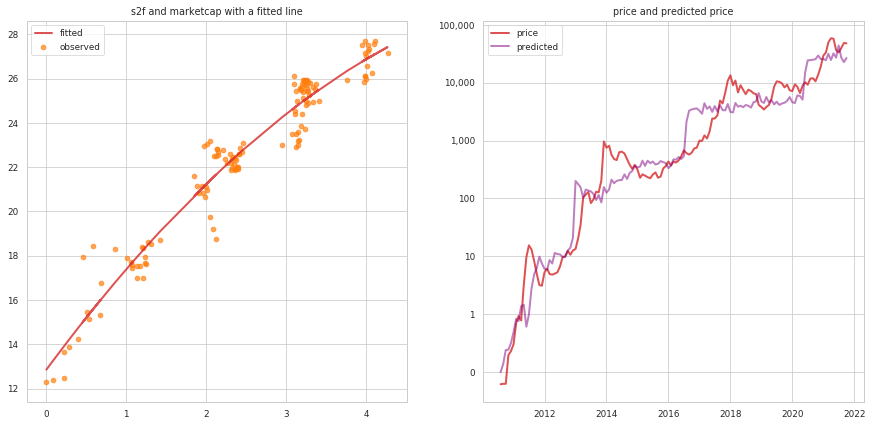

In [58]:
scatter_reg_poly(df22, clf_reg5, clf_reg6, 2)

In [59]:
# Predict the maximum marketcap for Bitcoin in theory
import math
lncap_pred_2d_max = clf_reg5.predict(poly2d.fit_transform(np.array([7.103393928854594]).reshape(-1, 1)))
print(math.exp(lncap_pred_2d_max))

12871706837897.213


In [60]:
# Predict the maximum price for Bitcoin in theory
import math
lnprice_pred_2d_max = clf_reg6.predict(poly2d.fit_transform(np.array([8.23667976734877]).reshape(-1, 1)))
print(math.exp(lnprice_pred_2d_max))

2258518.401289206


## Polynomial degree 2 for Litecoin marketcap and price

In [61]:
poly2d_ltc = PolynomialFeatures(degree=2, include_bias=False)
X9 = poly2d_ltc.fit_transform(df23['lns2f'].values.reshape(-1, 1))
y9 = df23['lncap'].values

# Model initialization for logarithm price
clf_reg7 = LinearRegression()
# Fit the data(train the model)
clf_reg7.fit(X9, y9)
# Predict
lncap_pred_2d_ltc = clf_reg7.predict(X9)
# print('Predicted ln(marketcap) for Litecoin: {}'.format(lncap_pred_2d_ltc))

In [62]:
# model evaluation
print("RMSE value: {}".format(mean_squared_error(y9, lncap_pred_2d_ltc)))
print("R2 score: {}".format(r2_score(y9, lncap_pred_2d_ltc)))
print("Slope: {0}, Intercept: {1}".format(clf_reg7.coef_, clf_reg7.intercept_))
f_statistic_7, p_value_7 = f_regression(X9, y9)
print("F-statistic: {0}, P-value: {1}".format(f_statistic_7, p_value_7))

RMSE value: 1.276074289131451
R2 score: 0.6321432338250261
Slope: [0.949971   0.19375913], Intercept: 17.54290185046642
F-statistic: [169.42702697 167.51519204], P-value: [2.49723157e-23 3.58060760e-23]


In [63]:
poly2d_ltc = PolynomialFeatures(degree=2, include_bias=False)
X10 = poly2d_ltc.fit_transform(df23['lns2f'].values.reshape(-1, 1))
y10 = df23['lnprice'].values

# Model initialization for logarithm price
clf_reg8 = LinearRegression()
# Fit the data(train the model)
clf_reg8.fit(X10, y10)
# Predict
lnprice_pred_2d_ltc = clf_reg8.predict(X10)
# print('Predicted ln(price) for Litecoin: {}'.format(lnprice_pred_2d_ltc))

In [64]:
# model evaluation
print("RMSE value: {}".format(mean_squared_error(y10, lnprice_pred_2d_ltc)))
print("R2 score: {}".format(r2_score(y10, lnprice_pred_2d_ltc)))
print("Slope: {0}, Intercept: {1}".format(clf_reg8.coef_, clf_reg8.intercept_))
f_statistic_8, p_value_8 = f_regression(X10, y10)
print("F-statistic: {0}, P-value: {1}".format(f_statistic_8, p_value_8))

RMSE value: 1.2034394068175636
R2 score: 0.5209672269722212
Slope: [0.04751383 0.31803167], Intercept: 1.160561029042069
F-statistic: [101.01440872 109.82892744], P-value: [6.94231947e-17 7.87533691e-18]


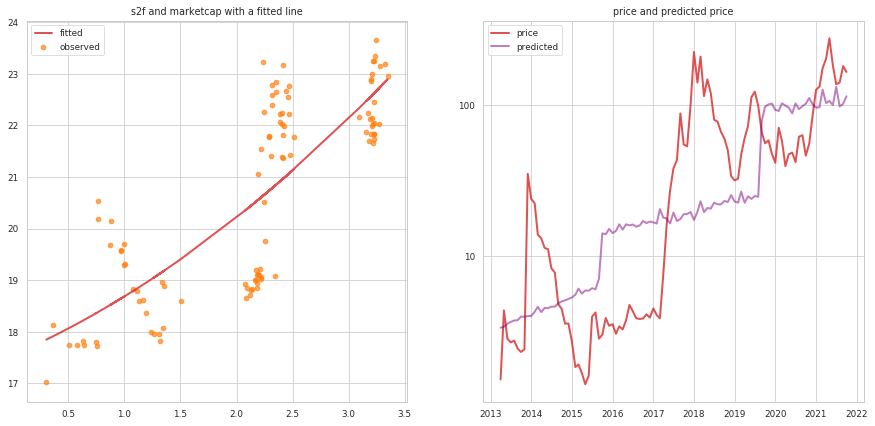

In [65]:
scatter_reg_poly(df23, clf_reg7, clf_reg8, 2)